In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


# **1) Libraries**

In [ ]:
import os
from os import listdir
import pandas as pd

import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2

import cv2
import numpy as np
import cv2
from keras.preprocessing import image
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import pickle

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, MaxPool2D , Flatten, Dense, Activation, Dropout, SpatialDropout2D, ZeroPadding2D, Convolution2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

import tensorflow as tf

from tensorflow.keras.utils import to_categorical


# **2) Loading dataset & Visualizing**

In [ ]:
directory_root = '/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/X-ray'
default_image_size = tuple((256, 256))

In [ ]:
def getCount(directory_root):
    food_list = listdir(f"{directory_root}") 
    dic_ = {}
    for label_folder in food_list:
      count = 1
      items = listdir(f"{directory_root}/{label_folder}") 
      for label in items:
        count+=1
      dic_[label_folder] =  count
    return dic_

In [ ]:
dic = getCount(directory_root)
labels = list(dic.keys())
values = list(dic.values())

{'Negative': 5399, 'Positive': 3936}

,Labels,Count
0,5399,Negative
1,3936,Positive


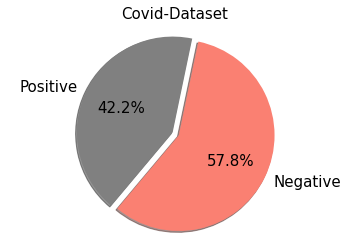

In [ ]:
df = pd.DataFrame(columns=['Labels','Count'])

df['Labels']=values
df['Count']=labels
display(df)

textprops = {"fontsize":15} # Font size of text in pie chart
fig1, ax1 = plt.subplots()

colors = ['salmon','grey']

ax1.pie(values, labels=labels, colors= colors, shadow= True,explode=(0.1, 0), textprops =textprops, radius = 1.4, 
        startangle=-130, autopct='%.1f%%')
ax1.axis('equal')
plt.title('Covid-Dataset', fontsize=15)
plt.show()

In [ ]:
def visualizeFoods(directory_root):
    food_list = listdir(f"{directory_root}") 
    plt.figure(figsize = (25,10))
    dic_ = {}

    count = 1
    for label_folder in food_list:
        items = listdir(f"{directory_root}/{label_folder}") 
        for label in items[:5]: 
            plt.subplot(2,5,count)
           
            image_directory = f"{directory_root}/{label_folder}/{label}"
            img = cv2.imread(image_directory)
            Image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(Image, cmap=plt.cm.bone)
            plt.xlabel(label_folder, fontsize=25)
            count+=1
    plt.show()

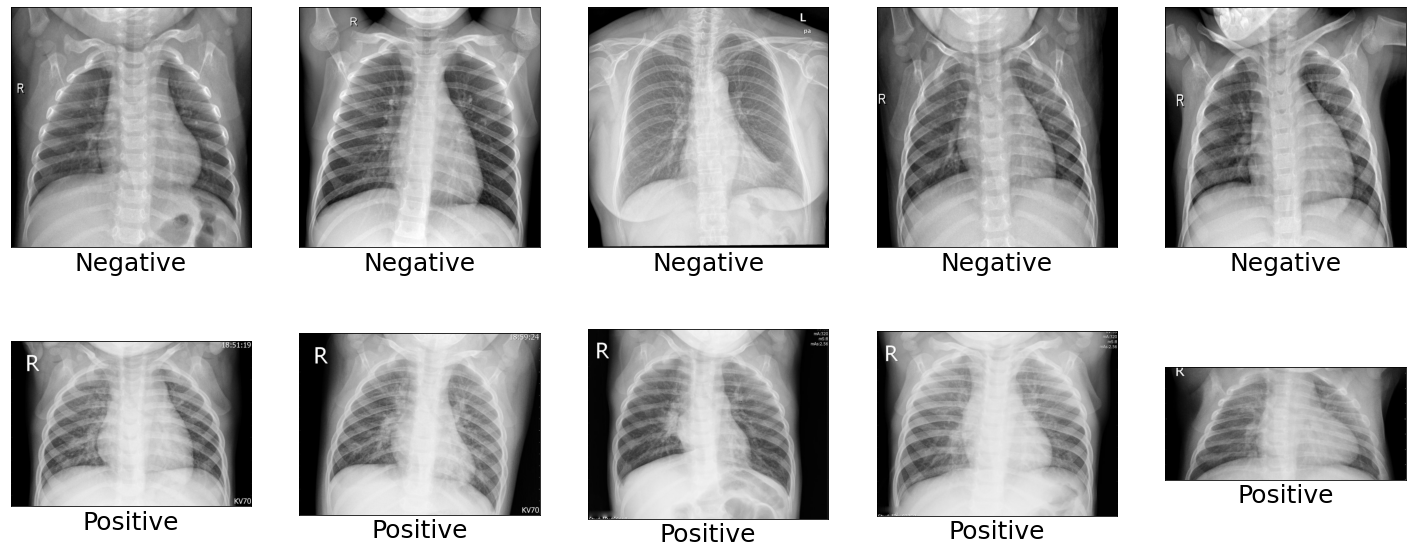

In [ ]:
visualizeFoods(directory_root)

# **3) Pre-Processing Image data & setting label**

In [ ]:
#Function to convert images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :",e)
        return None

In [ ]:
image_list, label_list = [], []
count = 0 
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for label_folder in root_dir:
        covid_folder_list = listdir(f"{directory_root}/{label_folder}") 
        print("Processing:",label_folder)
        for image in covid_folder_list[3000:]: # Execute Negative & Positive folder
            count+=1
            image_directory = f"{directory_root}/{label_folder}/{image}"
            image_list.append(convert_image_to_array(image_directory))
            label_list.append(label_folder)
    
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
image_labels_2 = to_categorical(image_labels)
pickle.dump(label_binarizer,open('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Covid-Detection/label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Negative' 'Positive']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels_2,#image_labels,
                                                    test_size=0.2, random_state = 42, shuffle=True) 

[INFO] Spliting data to train, test


In [ ]:
print(x_train.shape, y_train.shape, '\n',x_test.shape, y_test.shape)

(2666, 256, 256, 3) (2666, 2) 
 (667, 256, 256, 3) (667, 2)


In [ ]:
aug = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=False,
    fill_mode="nearest")

In [ ]:
# fit parameters from data
aug.fit(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


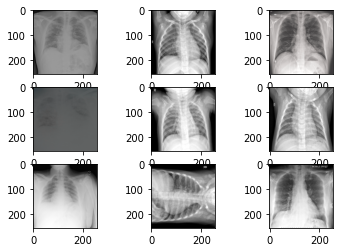

In [ ]:
# Configure batch size and retrieve one batch of images
for x_batch, y_batch in aug.flow(x_train, y_train, batch_size=32):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i])
    # show the plot
    plt.show()
    break

# **4) Modeling**

In [ ]:
EPOCHS = 100#50
INIT_LR = 1e-3
BS = 32
width=256
height=256
depth=3

### **i) VGG16 model**

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(input_shape=inputShape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1024,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)       2

In [ ]:
# train the network
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='mean_squared_error',
              optimizer = opt,metrics=["accuracy"])
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history_vgg16 = model.fit_generator(aug.flow(x_train,y_train,batch_size=BS),
                                    validation_data= (x_test, y_test),
                                    steps_per_epoch=len(x_train) // BS,
                                    epochs=EPOCHS,
                                    verbose=1)

Epoch 1/25
50/50 [==============================] - 75s 638ms/step - loss: 0.7174 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/25
50/50 [==============================] - 29s 572ms/step - loss: 0.6934 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 3/25
50/50 [==============================] - 28s 565ms/step - loss: 0.6935 - accuracy: 0.4994 - val_loss: 0.6933 - val_accuracy: 0.5025
Epoch 4/25
50/50 [==============================] - 27s 549ms/step - loss: 0.6945 - accuracy: 0.4994 - val_loss: 0.6933 - val_accuracy: 0.5025
Epoch 5/25
50/50 [==============================] - 28s 553ms/step - loss: 0.6937 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 6/25
50/50 [==============================] - 28s 555ms/step - loss: 0.6935 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 7/25
50/50 [==============================] - 27s 550ms/step - loss: 0.6931 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5025

In [ ]:
print("[INFO] Calculating VGG16 model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating VGG16 model accuracy
13/13 [==============================] - 2s 143ms/step - loss: 0.6931 - accuracy: 0.5025
Test Accuracy: 50.24999976158142


In [ ]:
print("[INFO] Saving VGG16 model H5...")
model.save("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/VGG16.h5")
print('model saved')

## **ii) VGG19**

In [ ]:
def VGG_19(weights_path=None):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(ZeroPadding2D((1,1),input_shape=inputShape))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=2, activation="softmax"))

    return model

In [ ]:
model_vgg_19 = VGG_19()
model_vgg_19.summary()

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_vgg_19.compile(loss='mean_squared_error',
              optimizer=opt,metrics=["accuracy"])
print("[INFO] training network...")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_16 (ZeroPaddi (None, 258, 258, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 258, 258, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
zero_padding2d_18 (ZeroPaddi (None, 130, 130, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 128)    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history_vgg19 = model_vgg_19.fit_generator(aug.flow(x_train,y_train,batch_size=BS),
                                    validation_data= (x_test, y_test),
                                    steps_per_epoch=len(x_train) // BS,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
50/50 [==============================] - 38s 730ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 2/25
50/50 [==============================] - 36s 723ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 3/25
50/50 [==============================] - 36s 726ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 4/25
50/50 [==============================] - 37s 735ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 5/25
50/50 [==============================] - 36s 730ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 6/25
50/50 [==============================] - 37s 742ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025
Epoch 7/25
50/50 [==============================] - 37s 747ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4975 - val_accuracy: 0.5025

In [ ]:
print("[INFO] Calculating VGG19 model accuracy")
scores_vgg_19 = model_vgg_19.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores_vgg_19[1]*100}")

[INFO] Calculating VGG19 model accuracy
13/13 [==============================] - 2s 181ms/step - loss: 0.4975 - accuracy: 0.5025
Test Accuracy: 50.24999976158142


In [ ]:
print("[INFO] Saving VGG19 model H5...")
model_vgg_19.save("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/VGG19.h5")
print('model saved')

[INFO] Saving VGG19 model H5...
model saved


## **iii) Custom model**

In [ ]:
model_custom = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model_custom.add(Conv2D(32, (3, 3), padding="same",activation="relu",input_shape=inputShape, strides=(1,1)))
model_custom.add(MaxPooling2D(pool_size=(3, 3)))

model_custom.add(Conv2D(64, (3, 3), padding="same",activation="relu", strides=(1,1)))
model_custom.add(Conv2D(64, (3, 3), padding="same",activation="relu", strides=(1,1)))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))

model_custom.add(Conv2D(128, (3, 3), padding="same",activation="relu", strides=(1,1)))
model_custom.add(Conv2D(128, (3, 3), padding="same",activation="relu", strides=(1,1)))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))

model_custom.add(Conv2D(512, (3, 3), padding="same",activation="relu", strides=(1,1)))
model_custom.add(Conv2D(512, (3, 3), padding="same",activation="relu", strides=(1,1)))
model_custom.add(Conv2D(512, (3, 3), padding="same",activation="relu", strides=(1,1)))
model_custom.add(MaxPooling2D(pool_size=(2, 2)))

model_custom.add(Flatten())
model_custom.add(Dense(1024, activation="relu"))
model_custom.add(Dropout(0.5))
model_custom.add(Dense(2,activation="softmax" ))

In [ ]:
#model_custom = tf.keras.models.load_model('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_11.h5')

In [ ]:
model_custom.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 128)       1

In [ ]:
opt = SGD(lr=INIT_LR)
model_custom.compile(loss='mean_squared_error',
              optimizer = opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_custom.fit_generator(aug.flow(x_train,y_train,batch_size=BS),
                                    validation_data= (x_test, y_test),
                                     steps_per_epoch=len(x_train) // BS,
                                     epochs=EPOCHS,
                                     verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
150/150 [==============================] - 29s 82ms/step - loss: 0.2498 - accuracy: 0.5377 - val_loss: 0.2496 - val_accuracy: 0.7242
Epoch 2/100
150/150 [==============================] - 11s 73ms/step - loss: 0.2495 - accuracy: 0.5537 - val_loss: 0.2493 - val_accuracy: 0.6967
Epoch 3/100
150/150 [==============================] - 11s 73ms/step - loss: 0.2492 - accuracy: 0.5858 - val_loss: 0.2490 - val_accuracy: 0.6858
Epoch 4/100
150/150 [==============================] - 11s 73ms/step - loss: 0.2490 - accuracy: 0.6025 - val_loss: 0.2488 - val_accuracy: 0.6883
Epoch 5/100
150/150 [==============================] - 11s 73ms/step - loss: 0.2488 - accuracy: 0.6192 - val_loss: 0.2486 - val_accuracy: 0.6800
Epoch 6/100
150/150 [==============================] - 11s 74ms/step - loss: 0.2486 - accuracy: 0.6435 - val_loss: 0.2483 - val_accuracy: 0.6692
Epoch 7/100
150/150 [==============================] - 11s 74ms/step - loss: 0.2483 - accuracy: 0.6308 - val_loss: 0.2481 - val_ac

In [ ]:
history = model_custom.fit_generator(aug.flow(x_train,y_train,batch_size=BS),
                                    validation_data= (x_test, y_test),
                                     steps_per_epoch=len(x_train) // BS,
                                     epochs=EPOCHS,
                                     verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
83/83 [==============================] - 8s 92ms/step - loss: 0.1317 - accuracy: 0.8098 - val_loss: 0.1135 - val_accuracy: 0.8471
Epoch 2/100
83/83 [==============================] - 6s 73ms/step - loss: 0.1177 - accuracy: 0.8405 - val_loss: 0.1078 - val_accuracy: 0.8576
Epoch 3/100
83/83 [==============================] - 6s 73ms/step - loss: 0.1116 - accuracy: 0.8443 - val_loss: 0.1068 - val_accuracy: 0.8606
Epoch 4/100
83/83 [==============================] - 6s 73ms/step - loss: 0.1084 - accuracy: 0.8557 - val_loss: 0.1083 - val_accuracy: 0.8441
Epoch 5/100
83/83 [==============================] - 6s 73ms/step - loss: 0.1058 - accuracy: 0.8588 - val_loss: 0.1111 - val_accuracy: 0.8531
Epoch 6/100
83/83 [==============================] - 6s 73ms/step - loss: 0.1045 - accuracy: 0.8573 - val_loss: 0.1056 - val_accuracy: 0.8666
Epoch 7/100
83/83 [==============================] - 6s 73ms/step - loss: 0.1009 - accuracy: 0.8694 - val_loss: 0.1030 - val_accuracy: 0.8561
Epoch 

# **5) Accuracy check of Custom model**

In [ ]:
print("[INFO] Calculating Custom model accuracy")
scores = model_custom.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating Custom model accuracy
21/21 [==============================] - 1s 27ms/step - loss: 0.0411 - accuracy: 0.9505
Test Accuracy: 95.05247473716736


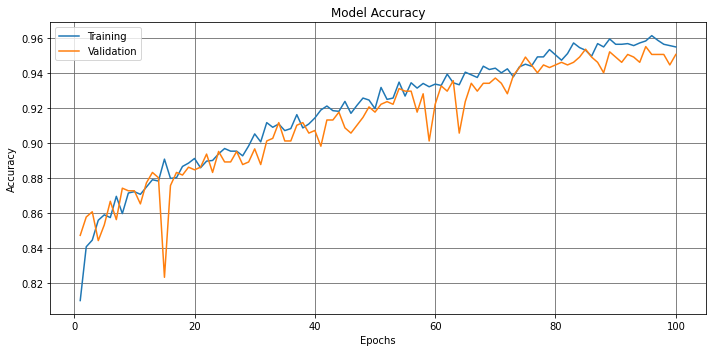

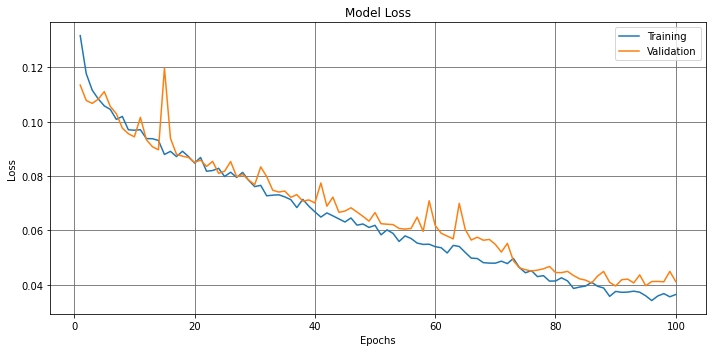

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

# **6) Saving Custom model**

### **i) Saving original model**

In [ ]:
print("[INFO] Saving Custom model H5...")
model_custom.save("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_11.h5")
print('model saved')

### **ii) Simple conversion of .h5 to .tflite**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_custom)
tflite_model = converter.convert()
open("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_11.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpe0mb8a23/assets


232085336

### **iii) Converting to quantized model**

In [ ]:
# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_custom)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open("/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_Quant_11.tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpawb125p7/assets


INFO:tensorflow:Assets written to: /tmp/tmpawb125p7/assets


58077248

# **7) Manual Testing of Custom Model**

In [ ]:
#Function to convert images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :",e)
        return None

In [ ]:
model_custom = tf.keras.models.load_model('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/Models/Custom_11.h5')
default_image_size = tuple((256, 256))

In [ ]:
image_list=[]

image_list.append(convert_image_to_array('/content/drive/My Drive/Semester 3/3406-AIML Capstone/Mendeley/X-ray/Positive/000007-2.png'))
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

result = model_custom.predict_proba(np_image_list)

reverse_mapping = ["Negative","Positive"]

#printing result
itemindex = np.where(result==np.max(result))

prediction_name = reverse_mapping[itemindex[1][0]]

print("Probability of " + prediction_name + "  is: " +str(np.max(result)))
print("Final Diagonasis result : " +prediction_name)

Probability of Positive  is: 0.53292036
Final Diagonasis result : Positive


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
